# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import os
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from openai import OpenAI
from dotenv import load_dotenv
from sentence_transformers import CrossEncoder

## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [3]:
df_news = pd.read_csv('../df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.
 
We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [4]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'], 
        'TICKER': row['TICKER'], 
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [7]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [8]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [9]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [12]:
# Sample 100 distinct news articles from the dataset
distinct_articles = df_news['SUMMARY'].drop_duplicates().sample(n=100, random_state=42)

In [22]:
# print the first element of the distinct_articles DF
print(distinct_articles.iloc[1])

Emerson Electric (EMR) has received quite a bit of attention from Zacks.com users lately. Therefore, it is wise to be aware of the facts that can impact the stock's prospects.


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [ ]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
open_ai = OpenAI(api_key=api_key)
model_gpt = "gpt-4o-mini"

### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset. 

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [28]:
prompt = """
Given the news headline provided below, 
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [ ]:
df_news_questions = pd.DataFrame(columns=["NEWS", "QUESTION"])

for i in range(len(distinct_articles)):
    response = open_ai.responses.create(
        model=model_gpt,
        input=prompt.format(news=distinct_articles.iloc[i])
    )
    df_news_questions.loc[len(df_news_questions)] = {
        "NEWS": distinct_articles.iloc[i],
        "QUESTION": response.output_text
    }

{'The market has shown positive momentum recently, with a 2.9% increase over the last week and a 12% rise over the past year, while earnings are expected to grow by 14% annually. In this environment, identifying strong dividend stocks can be crucial as they offer potential income and stability amid market growth.': 'What are the current trends in the market regarding growth and dividend stocks?', "Key Insights Solventum's estimated fair value is US$95.40 based on 2 Stage Free Cash Flow to Equity Solventum's...": "What is Solventum's estimated fair value based on the 2 Stage Free Cash Flow to Equity?", "It's been a good week for Verisk Analytics, Inc. ( NASDAQ:VRSK ) shareholders, because the company has just released...": 'What recent news has positively impacted shareholders of Verisk Analytics, Inc.?', "According to the average brokerage recommendation (ABR), one should invest in Take-Two (TTWO). It is debatable whether this highly sought-after metric is effective because Wall Street

In [29]:
print(df_news_questions.shape)
df_news_questions.head()

(100, 2)


,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What insights did Wall Street's top analysts p...
1,Emerson Electric (EMR) has received quite a bi...,What factors should investors consider when ev...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What are the earnings estimates for Ventas (VT...
3,Nvidia's earnings call this week will be a mar...,What key factors should investors pay attentio...
4,Inflation-scarred American consumers are putti...,Why are American consumers choosing to shop at...


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [ ]:
# Initializing new column with "not found"
df_news_questions["NO_RERANKER"] = "not found"

for i in range(len(df_news_questions)):
    item = df_news_questions.iloc[i]
    top_k = faiss_store.search(item["QUESTION"], k=5)

    for score_index, (summary, metadata, sim) in enumerate(top_k):
        if item["NEWS"] == summary:
            df_news_questions.at[i, "NO_RERANKER"] = score_index
            break


In [39]:
df_news_questions.head(15)

,NEWS,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What insights did Wall Street's top analysts p...,0
1,Emerson Electric (EMR) has received quite a bi...,What factors should investors consider when ev...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What are the earnings estimates for Ventas (VT...,0
3,Nvidia's earnings call this week will be a mar...,What key factors should investors pay attentio...,0
4,Inflation-scarred American consumers are putti...,Why are American consumers choosing to shop at...,0
5,Delivery service DoorDash (DASH) reported its ...,What factors are contributing to DoorDash's sh...,1
6,Strong capital efficiency and commercial growt...,What are the reasons investors are cautious ab...,0
7,Argus recently lowered the price target on Equ...,What factors contributed to Argus lowering the...,0
8,The Zacks Internet software industry participa...,"How are companies like ANET, MNDY, and PCTY ca...",0
9,This marks the ninth time in 37 years this uns...,What implications does the company's ninth for...,0


### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [48]:
model_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model_encoder.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
    ("How many people live in Berlin?", "Paris is the capital of France."),
    ("How many people live in Berlin?", "Berlin is the capital of Germany."),
])
top_2_scores = np.argsort(scores)[-2:][::-1]
print(top_2_scores)

[0 3]


In [ ]:
# Initializing new column with "not found"
df_news_questions["WITH_RERANKER"] = "not found"

for i in range(len(df_news_questions)):
    item = df_news_questions.iloc[i]
    top_k = faiss_store.search(item["QUESTION"], k=100)
    question_summaries = []

    for summary, _, _ in top_k:
        question_summaries.append((item["QUESTION"], summary))

    scores = model_encoder.predict(question_summaries)
    top_5_scores = np.argsort(scores)[-5:][::-1]

    for rank, score_index in enumerate(top_5_scores):
        summary, _, _ = top_k[score_index]
        if item["NEWS"] == summary:
            df_news_questions.at[i, "WITH_RERANKER"] = rank
            break


In [52]:
df_news_questions.head(35)

,NEWS,QUESTION,NO_RERANKER,WITH_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What insights did Wall Street's top analysts p...,0,0
1,Emerson Electric (EMR) has received quite a bi...,What factors should investors consider when ev...,0,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What are the earnings estimates for Ventas (VT...,0,2
3,Nvidia's earnings call this week will be a mar...,What key factors should investors pay attentio...,0,0
4,Inflation-scarred American consumers are putti...,Why are American consumers choosing to shop at...,0,0
5,Delivery service DoorDash (DASH) reported its ...,What factors are contributing to DoorDash's sh...,1,0
6,Strong capital efficiency and commercial growt...,What are the reasons investors are cautious ab...,0,0
7,Argus recently lowered the price target on Equ...,What factors contributed to Argus lowering the...,0,0
8,The Zacks Internet software industry participa...,"How are companies like ANET, MNDY, and PCTY ca...",0,0
9,This marks the ninth time in 37 years this uns...,What implications does the company's ninth for...,0,0


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

In [57]:
df_news_questions["NO_RERANKER"].value_counts()

NO_RERANKER
0            90
not found     6
1             4
Name: count, dtype: int64

In [58]:
df_news_questions["WITH_RERANKER"].value_counts()

WITH_RERANKER
0            92
not found     3
2             2
1             2
4             1
Name: count, dtype: int64

In [64]:
df_news_questions["NO_RERANKER"].replace("not found", np.nan, inplace=True)
df_news_questions["NO_RERANKER"].mean(), df_news_questions["NO_RERANKER"].median()

(np.float64(0.0425531914893617), np.float64(0.0))

In [66]:
df_news_questions["WITH_RERANKER"].replace("not found", np.nan, inplace=True)
df_news_questions["WITH_RERANKER"].mean(), df_news_questions["WITH_RERANKER"].median()

(np.float64(0.10309278350515463), np.float64(0.0))

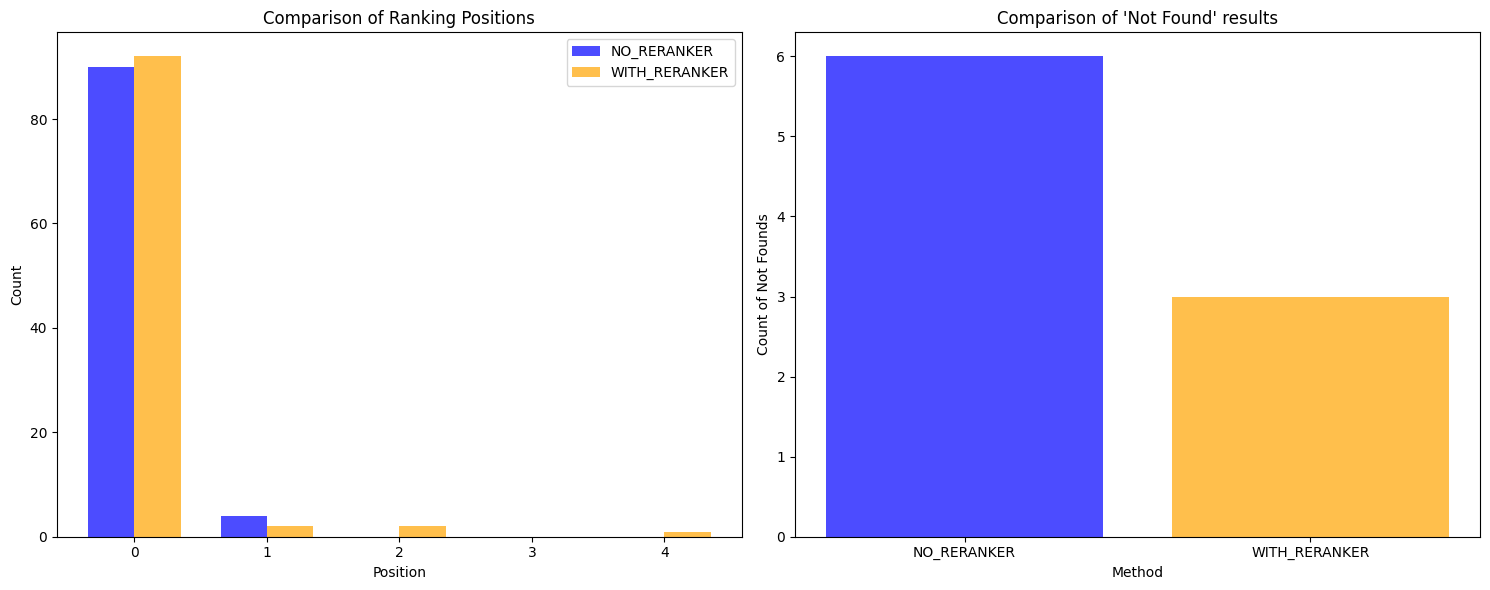

In [ ]:
# Comparison plots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot - Ranking positions comparison
no_reranker_counts = df_news_questions["NO_RERANKER"].value_counts().sort_index()
with_reranker_counts = df_news_questions["WITH_RERANKER"].value_counts().sort_index()
positions = [0, 1, 2, 3, 4]
no_reranker_values = [no_reranker_counts.get(pos, 0) for pos in positions]
with_reranker_values = [with_reranker_counts.get(pos, 0) for pos in positions]

x = np.arange(len(positions))
bar_width = 0.35

ax1.bar(x - bar_width/2, no_reranker_values, bar_width, label='NO_RERANKER', color='blue', alpha=0.7)
ax1.bar(x + bar_width/2, with_reranker_values, bar_width, label='WITH_RERANKER', color='orange', alpha=0.7)
ax1.set_xlabel('Position')
ax1.set_ylabel('Count')
ax1.set_title('Comparison of Ranking Positions')
ax1.set_xticks(x)
ax1.set_xticklabels(positions)
ax1.legend()

# Second subplot - Not found comparison
na_counts = df_news_questions[["NO_RERANKER", "WITH_RERANKER"]].isna().sum()
ax2.bar(na_counts.index, na_counts.values, color=["blue", "orange"], alpha=0.7)
ax2.set_title("Comparison of 'Not Found' results")
ax2.set_xlabel("Method")
ax2.set_ylabel("Count of Not Founds")
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


### **Question 1.** Did reranking improve the **average position** of the correct news?
 

| Method          | Average Position | Not Found Cases |
|------------------|------------------|------------------|
| With re-ranking   | **0.103**        | **3**            |
| Without re-ranking| **0.042**        | **6**            |

Excluding the "not found" cases, the average position indicates that re-ranking got higher values, but this is misleading, since the amount of "not found" cases is not taken into account.

We can see that the number of "not found" cases is lower for the re-ranking method, indicating that it may be more effective in retrieving relevant information. Because it is able to find relevant documents more consistently, leading to a better overall performance in terms of retrieval success.

When the "not found" cases are taken into account, the picture becomes clearer. The re-ranking method not only retrieves relevant documents more effectively but also reduces the instances where no relevant documents are found at all.

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


| Method          | Position 0 | Position 1 | Position 2 |  Position 3 | Position 4 | Not Found Cases |
|------------------|------------|------------|------------|-------------|------------|------------------|
| With re-ranking   | **92**     | 2      | 2      | 0       | 1      | 3            |
| Without re-ranking| **90**     | 4     | 0     | 0      | 0      | 6           |

The results indicate that the re-ranking method is more effective in retrieving relevant documents, as evidenced by the higher number of documents found in the position zero (first place) and the lower number of "not found" cases (last place).

When analyzing the distribution of retrieved documents across different positions, we can see that the re-ranking method not only improves the top results but also maintains a more balanced retrieval performance across all positions.
